In [1]:
import pandas as pd
import openai
import time
import re
import gc
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mean_absolute_error
import pickle
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import datetime 
import sys
sys.path.append('../experiment_01')
from sidemethods import logprobs_from_prompt, proc, proc_lower, prob_of_ending
import torch
import random
cuda_avail=torch.cuda.is_available()
print('cuda available:', cuda_avail)

RATE_LIMIT = 0.1 # seconds of pause needed after every OpenAI API call

try:
    with open("../../hf.key", "r") as f_in:
        hf_key = f_in.readline().strip()
except:
    print('hf.key not found')
try:
    api_key = open('openai.key', 'r').read()
    openai.api_key = api_key
except:
    print('openai.key not found')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


cuda available: False
hf.key not found


# Prompt Preperation and Helper Methods

In [2]:
exp_2_df = pd.read_csv('../../data/Beitel_Exp2.csv', sep=';')
exp_3_df = pd.read_csv('../../data/Gibbs_Exp3.csv', sep=';')
# drop nan rows
exp_3_df = exp_3_df.dropna()
exp_4_df = pd.read_csv('../../data/Gibbs_Exp4.csv', sep=';')
STIMULI_EXP2 = exp_2_df['Stimulus'].values
STIMULI_EXP3 = exp_3_df['Stimulus'].values
STIMULI_EXP4 = exp_4_df['Stimulus'].values
print(len(STIMULI_EXP2))
print(len(STIMULI_EXP3))
print(len(STIMULI_EXP4))

37
32
32


Description from Gibbs paper: 
- The participants in this study were first asked to stand up and focus on different aspects of their bodily experience of standing in the same way as did participants in Experiment 1.
- Following this, we introduced the five image schemas of BALANCE, VERTICALITY, CENTER-PERIPHERY, RESISTANCE, and LINKAGE as was done in Experiment 1


Description from Beitel paper:
- Prior to the experiment, the participants received the descriptions of all five image schemas in relation to a sample typical use of on. The sample use of on was not included as the test item.

In [3]:
DEFINITIONS = {
    "VERTICALITY": "Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.",
    "BALANCE": "Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.",
    "CENTER-PERIPHERY": "Consider the notion of CENTER-PERIPHERY. Center-periphery refers to the experience of some objects or events as central while surrounding objects and events are peripheral or to the outside.",
    "LINKAGE": "Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.",
    "RESISTANCE": "Consider the notion of RESISTANCE. Resistance refers to the experience of your body opposing some external force."
}

DEFINITIONS_2_INTRO='In the case of the use of "on" in "the book is on the desk":'
DEFINITIONS_2 = {
    "SUPPORT": "the SUPPORT relation refers to the desk supporting the book.",
    "PRESSURE": "the PRESSURE relation refers to the book exerting some pressure on the desk.",
    "CONSTRAINT": "the CONSTRAINT relation refers to the desk constraining the possible motions of the book.",
    "COVERING": "the COVERING relation refers to the book concealing the part of the desk that is under the book.",   
    "VISIBILITY": "the VISIBILITY relation refers to the book being visible on the desk."
}

In [4]:
# create prompts
prompts_exp2 = {"SUPPORT":[], "PRESSURE":[], "CONSTRAINT":[], "COVERING":[], "VISIBILITY":[]}
prompts_exp3 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}
prompts_exp4 = {"VERTICALITY":[], "BALANCE":[], "CENTER-PERIPHERY":[], "LINKAGE":[], "RESISTANCE":[]}



for i in range(len(STIMULI_EXP2)):
    for key in DEFINITIONS_2:
        prompt_ending =  'On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept '+key+' in regards to the phrase: "' + STIMULI_EXP2[i] + '"?'
        prompts_exp2[key].append(DEFINITIONS_2_INTRO + " " + DEFINITIONS_2[key] + "\n" + prompt_ending)

for i in range(len(STIMULI_EXP3)):
    prompt_ending =  'How strongly is the phrase "' + STIMULI_EXP3[i] + '" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?'
    prompts_exp3["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp3["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp3["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp3["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp3["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

for i in range(len(STIMULI_EXP4)):
    prompt_ending =  'How strongly is the phrase "' + STIMULI_EXP4[i] + '" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?'
    prompts_exp4["VERTICALITY"].append(DEFINITIONS["VERTICALITY"] + "\n" + prompt_ending)
    prompts_exp4["BALANCE"].append(DEFINITIONS["BALANCE"] + "\n" + prompt_ending)
    prompts_exp4["CENTER-PERIPHERY"].append(DEFINITIONS["CENTER-PERIPHERY"] + "\n" + prompt_ending)
    prompts_exp4["LINKAGE"].append(DEFINITIONS["LINKAGE"] + "\n" + prompt_ending)
    prompts_exp4["RESISTANCE"].append(DEFINITIONS["RESISTANCE"] + "\n" + prompt_ending)

# example prompts
print(prompts_exp2["SUPPORT"][0], "\n")
print(prompts_exp3["BALANCE"][0])

In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supporting the book.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept SUPPORT in regards to the phrase: "The family depends on the father"? 

Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.
How strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?


In [5]:
# variants with which GPT can be prompted to generate the questionnaire answers
def gpt_complete(prompt, model, max_tokens, prompt_ending, verbose=False):
    temperature = 0
    prompt=prompt+prompt_ending
    if verbose: print("Prompt:", prompt)
    # the create functiosn differ for chat and non-chat models
    if ("gpt-4" in model or "turbo" in model) and not "instruct" in model:
        system_message="You are a participant in a research experiment."
        return openai.ChatCompletion.create(
            model=model,
            messages=[ {"role": "system", "content": system_message},
                {"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=max_tokens
            )
    else:
        return openai.Completion.create(
            model=model,
            prompt=prompt,
            temperature=temperature,
            max_tokens=max_tokens
        ) 

def gpt_complete_proba(prompt, model, prompt_ending, verbose=False):
    # get the probability distribution over the next token for the tokens 1, 2, 3, 4, 5, 6, 7
    temperature = 0
    proba_list = []
    debug = []
    for i in range(1, 8):
        next_prompt = prompt + prompt_ending + str(i)
        if verbose: print("Prompt:", next_prompt)
        
        if ("gpt-4" in model or "turbo" in model) and not "instruct" in model:
            system_message="You are a participant in a research experiment."
            result = openai.ChatCompletion.create(                                          # this model type did not support logprobs at time of the experiments
                model=model,
                messages=[ {"role": "system", "content": system_message},
                    {"role": "user", "content": next_prompt}],
                temperature=temperature,
                max_tokens=1,
            )

        else:
            result = openai.Completion.create(
                model=model,
                prompt=next_prompt,
                max_tokens=1,
                temperature=temperature,
                logprobs=1,
                echo=True
            )
        debug.append(result)
        print(result["choices"][0]["logprobs"]["tokens"])
        # the index of i in the list of tokens
        tokens = result["choices"][0]["logprobs"]["tokens"]
        # strip whitespace
        tokens = [tok.strip() for tok in tokens]
        index = [num for num, tok in enumerate(tokens) if tok == str(i)][-1] # -1 to get the last occurence since 1 and 7 are also part of the input prompt
        print("index:", index)
        print("log prob:", result["choices"][0]["logprobs"]["token_logprobs"][index])
        print("prob:", np.exp(result["choices"][0]["logprobs"]["token_logprobs"][index]))
        print("token:", result["choices"][0]["logprobs"]["tokens"][index])
        print()
        log_prob_result=result["choices"][0]["logprobs"]["token_logprobs"][index]
        prob_result = np.exp(log_prob_result)
        proba_list.append(prob_result)
        # wait to avoid exceeding the API rate limit
        time.sleep(RATE_LIMIT)      
    average_completion = 0
    for i in range(1, 8):
        average_completion += i * proba_list[i-1]
    average_completion = average_completion / sum(proba_list)    

    return proba_list, average_completion, debug

In [6]:
def save_generations_to_csv(completions_clean, stimuli, exp_name, completions=None):    #completions is a dict with IS as keys and completions as values
    # ratings
    df = pd.DataFrame.from_dict(completions_clean)
    # stimuli
    df.insert(0, 'Stimulus', stimuli)
    # original completions
    completions_text={}     
    if completions != None:
        for k in completions:
            completions_text[k]=[]
            for i in range(len(completions[k])):
                try:
                    completions_text[k].append(completions[k][i]["choices"][0]["text"]) # if from openai
                except:
                    try:
                        completions_text[k].append(completions[k][i]["choices"][0]["message"]["content"]) # if from openai chat
                    except:
                        completions_text[k].append(completions[k][i]) # if from huggingface
        # add to df as last column
        for k in completions_text:
            df.insert(len(df.columns),  k+"_Completion_Text", completions_text[k])

    date = datetime.datetime.now().strftime("%Y-%m-%d")
    df.to_csv('lm_generations/df_' + exp_name + '_' + date + '.csv', index=False)
    print('Saved as df_' + exp_name + '_' + date + '.csv')

In [13]:
prompt = 'Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.\nHow strongly are the phrases "stand in awe" and "the clock stands on the mantle" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)? Only answer with the two scores: \n\n"'
res = gpt_complete(prompt=prompt, model="gpt-4", max_tokens=20, prompt_ending="", verbose=True)
print(res)

Prompt: Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.
How strongly are the phrases "stand in awe" and "the clock stands on the mantle" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)? Only answer with the two scores: 

"
{
  "id": "chatcmpl-8Xr6LdK7pBlwTk1hgDcNFg4oHCNKK",
  "object": "chat.completion",
  "created": 1703079637,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "stand in awe\": 2\n\"the clock stands on the mantle\": 4"
      },
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 96,
    "completion_tokens": 17,
    "total_tokens": 113
  },
  "system_fingerprint": null
}


# Finding a Good Way of How to End a Prompt 
Maximize valid answers without looking at the content of the answer!

We will also check if the content of the ouput differs a lot or stays rather similar.

In [8]:
def log_prob_sum(input_samples, model, tokenizer, prompt_ending, hf):
    '''
    compute the sum of log probabilities attributed to the 7 allowed scores over x=len(input_samples) samples

    input_samples: list of prompts
    model: the model to use, either a string of a gpt model or a loaded huggingface model object
    tokenizer: huggingface tokenizer object
    prompt_ending: the string that is appended to the prompt
    hf: whether to use huggingface or gpt
    '''
    proba_sum = 0
    avg_output_list = []    #this contains probability-averaged likert scores per prompt
    for prompt in input_samples:
        if hf:
            proba_list, avg_likert, _ = hf_complete_proba(prompt=prompt, model=model, tokenizer=tokenizer, prompt_ending=prompt_ending, verbose=False)
        else:
            proba_list, avg_likert, debug = gpt_complete_proba(prompt, model, prompt_ending, verbose=True)
        proba_sum += sum(proba_list)
        avg_output_list.append(avg_likert)
    return proba_sum, avg_output_list       # return sum and the list of averaged likert scores per prompt


In [9]:
def find_best_ending(model, tokenizer, prompt_endings, hf):
    '''
    given a list of prompt endings, find the one that maximizes the probability sum over the 7 likert scores

    model: the model to use, either a string of a gpt model or a loaded huggingface model object
    tokenizer: huggingface tokenizer object
    prompt_endings: list of prompt endings to test
    hf: whether to use huggingface or gpt
    '''
    
    test_inputs=[]
    score_sums=[]
    for k in prompts_exp3:                      # EXPERIMENT-DEPENDENT!!
        for p in prompts_exp3[k][0:3]:         
            test_inputs.append(p)                                                                    
    print(test_inputs)    
    print("Number of inputs used to compute probability sum:", len(test_inputs))     


    output_lists=[]             # list containing the avg. generated likert scores 
    for ending in prompt_endings:
        print("Testing Prompt Ending:", ending)
        proba_sum, output_list=log_prob_sum(input_samples=test_inputs, model=model, tokenizer=tokenizer, prompt_ending=ending, hf=hf)
        score_sums.append(proba_sum)   
        output_lists.append(output_list)

    # print results
    for i in range(len(prompt_endings)):
        print("Prompt Ending:", prompt_endings[i].replace("\n", "\\n"))
        print("Probability Sum:", score_sums[i])
        print("Average Probability:", score_sums[i]/len(test_inputs))
        # compute avg. difference in output_list to the other output_lists
        for j in range(len(prompt_endings)):
            if i!=j:
                print("Average score difference to Prompt Ending", prompt_endings[j].replace("\n","\\n"), ":", 
                    np.mean(np.abs(np.array(output_lists[i])-np.array(output_lists[j]))))
        print()



In [22]:
model = "text-davinci-002"     
prompt_endings=[" Only answer with the score! \nI choose the score ", " A research participant would choose the number ", " I choose the number "]

find_best_ending(model, prompt_endings)

['Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (no

In [148]:
model = "text-davinci-003"     
prompt_endings=[" Only answer with the score: \n\n", "\n\n", "\n", " Only answer with the score! \nI choose the score ", " A research participant would choose the number \n", " I choose the number "]

find_best_ending(model, prompt_endings)

['Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (no

# Single Prompts Experiments

We generate the answers with the following models:
- text-davinci-003 (GPT 3.5 instruction-tuned)
- davinci-002   (Base GPT-3)
- gpt-4
- llama2 13b chat   
- llama2 70b chat 

In [11]:
def get_all_completions(model, prompts, prompt_ending, proba_version, save_name="", verbose=False):
    '''
    for all image schemas and all items, get completions and completions_logprobs

    model: str, the model to use
    prompts: dict, the prompts to use, with image schemas as keys and lists of prompts as values
    prompt_ending: str, the prompt ending to append to each prompt
    save_name: str, the name to use when saving the results as pickle
    verbose: bool, whether to print the prompts
    '''
    completions={}
    completions_logprobs={}
    for key in prompts:
        completions[key]=[]
        completions_logprobs[key]=[]
        for i in range(len(prompts[key])):
            if verbose: print("Prompt:", prompts[key][i])
            completions[key].append(gpt_complete(prompt=prompts[key][i], model=model, max_tokens=10, prompt_ending=prompt_ending))
            time.sleep(RATE_LIMIT)
            if proba_version: 
                completions_logprobs[key].append(gpt_complete_proba(prompt=prompts[key][i], model=model, prompt_ending=prompt_ending))
        print("Finished with", key)
    
    # saver results as pickle
    if save_name!="":
        save_name="pkl_saves/"+save_name
        date = datetime.datetime.now().strftime("%Y-%m-%d")
        with open(save_name + '_' + model + '_' + date + '.pkl', 'wb') as f:
            pickle.dump(completions, f)
        if proba_version:
            with open(save_name + '_logprobs_' + model + '_' + date + '.pkl', 'wb') as f:
                pickle.dump(completions_logprobs, f)

    return completions, completions_logprobs

In [12]:
def extract_completions(completions):   
    '''
    extract the model's actual scores from the completions (i.e. digits from string) and return them in a dict, the same format as the human data.
    print the unedited output to check manually for errors. 
    '''
    completions_clean = {}
    for key in completions:
        completions_clean[key]=[]
        for i in range(len(completions[key])):
            try:
                text_output=completions[key][i]["choices"][0]["text"]
            except: # chat versions of gpt
                text_output=completions[key][i]["choices"][0]["message"]["content"]
            print("\noriginal:",text_output)
            try:
                clean_item = int(re.findall(r'\d+', text_output)[0]) # takes the first number that appears in the string
            except:
                print("error with item: ", clean_item)
                clean_item = 0
            completions_clean[key].append(clean_item)
    return completions_clean


def extract_completions_logprob(completions_logprob):
    '''
    same but for the logprob version
    '''
    completions_clean = {}
    for key in completions_logprob:
        completions_clean[key]=[]
        for i in range(len(completions_logprob[key])):
            avg_score=completions_logprob[key][i][1]
            completions_clean[key].append(avg_score)
    return completions_clean
    

## Beitel Experiment

In [64]:
# example for how to get results with a specific model, in this case gpt-4
with_logprobs = False
model="gpt-4"
completions_exp2, _ = get_all_completions(model=model, prompts=prompts_exp2, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp2", verbose=True, proba_version=with_logprobs)
# extract the actual ratings
completions_clean_exp2 = extract_completions(completions_exp2)
if with_logprobs: 
    completions_clean_exp2_logprobs=extract_completions_logprob(completions_logprobs_exp2)
# save
save_generations_to_csv(completions=completions_exp2, stimuli=STIMULI_EXP2, exp_name="single_prompt_exp2_"+model, completions_clean=completions_clean_exp2)
if with_logprobs:
    save_generations_to_csv(stimuli=STIMULI_EXP2, exp_name="single_prompt_exp2_"+model+"_logprobs", completions_clean=completions_clean_exp2_logprobs)

Prompt: In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supporting the book.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept SUPPORT in regards to the phrase: "The family depends on the father"?
Prompt: In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supporting the book.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept SUPPORT in regards to the phrase: "There is a physician on call"?
Prompt: In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supporting the book.
On a scale from 1 (not at all appropriate) to 7 (very appropriate), how appropriate is the concept SUPPORT in regards to the phrase: "All books are on sale"?
Prompt: In the case of the use of "on" in "the book is on the desk": the SUPPORT relation refers to the desk supportin

## Gibbs (Stand) Experiment

In [75]:
# example for how to get results with a specific model, in this case gpt-4
with_logprobs = False
model = "gpt-4"
completions_exp3, completions_exp3_logprobs = get_all_completions(model=model, prompts=prompts_exp3, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp3", verbose=True, proba_version=with_logprobs)
# extract the actual ratings
completions_clean_exp3 = extract_completions(completions_exp3)
if with_logprobs: completions_clean_exp3_logprobs=extract_completions_logprob(completions_exp3_logprobs)
# save
save_generations_to_csv(completions=completions_exp3, stimuli=STIMULI_EXP3, exp_name="single_prompt_exp3_"+model, completions_clean=completions_clean_exp3)
if with_logprobs: save_generations_to_csv(stimuli=STIMULI_EXP3, exp_name="single_prompt_exp3_"+model+"_logprobs", completions_clean=completions_clean_exp3_logprobs)

Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "don't stand for such treatment" related to this notion on a 

## Gibbs (Synonym) Experiment

In [78]:
with_logprobs = False
model="gpt-4"
completions_exp4, completions_exp4_logprobs = get_all_completions(model=model, prompts=prompts_exp4, prompt_ending=" Only answer with the score: \n\n", save_name="completions_exp4", verbose=True, proba_version=with_logprobs)

completions_clean_exp4 = extract_completions(completions_exp4)
if with_logprobs: completions_clean_exp4_logprobs=extract_completions_logprob(completions_logprobs_exp4)

save_generations_to_csv(completions=completions_exp4, stimuli=STIMULI_EXP4, exp_name="single_prompt_exp4_"+model, completions_clean=completions_clean_exp4)
if with_logprobs: save_generations_to_csv(stimuli=STIMULI_EXP4, exp_name="single_prompt_exp4_"+model+"_logprobs", completions_clean=completions_clean_exp4_logprobs)

Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "be at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "be distinguished in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "to hold firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "don't allow such treatment" related to this notion on a s

## Huggingface

Repeat experiments as above but with the HF library

In [10]:
def hf_complete(prompt, prompt_ending, model, tokenizer, sampling, max_len):
    '''
    Given a prompt, generate a completion with a given model
    '''
    prompt = prompt + prompt_ending
    # Step 1: Tokenize the prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    input_ids = input_ids.to(model.device)
    
    # Step 2: Generate the model input
    if sampling:
        # TODO make sampling params explicit --> temp, top_k
        output = model.generate(input_ids, max_new_tokens=max_len, num_return_sequences=1)
    else: 
        output = model.generate(input_ids, max_new_tokens=max_len, num_return_sequences=1, top_k=1)
        
    
    # Step 3: Decode the generated output to get the answer
    generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Step 4: Print the answer
    return generated_answer

def hf_complete_proba(prompt, prompt_ending, model, tokenizer, verbose):
    answers = {0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7"}

    start = prompt+prompt_ending

    res_ends = []
    proba_list = []
    for j, end in answers.items():
        input_prompt = start+end 
        if verbose: print(input_prompt)
        logprobs = logprobs_from_prompt(input_prompt, tokenizer, model)
        res = {"tokens": [x for x,y in logprobs],"token_logprobs": [y for x,y in logprobs]}
        res_ends.append(res)
        proba_list.append(np.exp(res["token_logprobs"][-1]))
        if verbose:print(end, res, "\n")

    average_completion = 0
    for i in range(len(proba_list)):
        average_completion += (i+1) * proba_list[i]
    average_completion = average_completion / sum(proba_list)      
        
    return proba_list, average_completion, res_ends

In [15]:
#70b
hf_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-70b-chat-hf", cache_dir="../../../models/l70b_chat", token=hf_key)
hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-70b-chat-hf",  cache_dir="../../../models/l70b_chat", token=hf_key, device_map="auto")

#13b
#hf_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-chat-hf", cache_dir="../../../models/l13b_chat", token=hf_key)
#hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-13b-chat-hf",  cache_dir="../../../models/l13b_chat", token=hf_key, device_map="auto")

#7b
#hf_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", cache_dir="../../../models/l7b_chat", token=hf_key)
#hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf",  cache_dir="../../../models/l7b_chat", token=hf_key, device_map="auto")


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [44]:
# how to end a prompt with 13b
prompt_endings=[" Only answer with the score! \nI choose the score ", " A research participant would choose the number ", " I choose the number "]
find_best_ending(model=hf_model, tokenizer=hf_tokenizer, prompt_endings=prompt_endings, hf=True)

['Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (no

In [24]:
# how to end a prompt with 7b
prompt_endings=[" Only answer with the score! \n\n"," I choose the number "]
find_best_ending(model=hf_model, tokenizer=hf_tokenizer, prompt_endings=prompt_endings, hf=True)

['Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "stand out in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.\nHow strongly is the phrase "to stand firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?', 'Consider the notion of BALANCE. Balance refers to your sense of symmetry or stability relative to some point within your body.\nHow strongly is the phrase "stand at attention" related to this notion on a scale from 1 (no

### Get Completions Huggingface

In [17]:
def get_all_completions_hf(model, tokenizer, prompts, prompt_ending, proba_version, max_len, model_name, save_name="", verbose=False):
    '''
    for all image schemas and all items, get completions and completions_logprobs

    model: the huggingface model to use
    tokenizer: the huggingface tokenizer to use
    prompts: dict, the prompts to use, with image schemas as keys and lists of prompts as values
    prompt_ending: str, the prompt ending to append to each prompt
    save_name: str, the name to use when saving the results as pickle
    verbose: bool, whether to print the prompts
    '''
    completions={}
    completions_logprobs={}
    for key in prompts:
        completions[key]=[]
        completions_logprobs[key]=[]
        for i in range(len(prompts[key])):
            if verbose: print("Prompt:", prompts[key][i])
            completions[key].append(hf_complete(prompt=prompts[key][i], prompt_ending=prompt_ending, model=model, tokenizer=tokenizer, sampling=False, max_len=max_len))
            if proba_version: 
                completions_logprobs[key].append(hf_complete_proba(prompt=prompts[key][i], prompt_ending=prompt_ending, model=model, tokenizer=tokenizer, verbose=False))
        print("Finished with", key)
    
    # saver results as pickle
    if save_name!="":
        save_name="pkl_saves/"+save_name
        date = datetime.datetime.now().strftime("%Y-%m-%d")
        with open(save_name + '_' + model_name + '_' + date + '.pkl', 'wb') as f:
            pickle.dump(completions, f)
        if proba_version:
            with open(save_name + '_logprobs_' + model_name + '_' + date + '.pkl', 'wb') as f:
                pickle.dump(completions_logprobs, f)

    return completions, completions_logprobs

In [15]:
def extract_completions(completions, prompt_ending_used):   
    '''
    extract the model's actual scores from the completions (i.e. digits from string) and return them in a dict, the same format as the human data.
    print the unedited output to check manually for errors. 
    '''
    completions_clean = {}
    for key in completions:
        completions_clean[key]=[]
        for i in range(len(completions[key])):
            text_output=completions[key][i]
            # split after prompt_ending_used
            text_output = text_output.split(prompt_ending_used)[1]
            print("\noriginal:",text_output)
            try:
                clean_item = int(re.findall(r'\d+', text_output)[0]) # takes the first number that appears in the string
            except:
                print("error with item: ", clean_item)
                clean_item = 0
            completions_clean[key].append(clean_item)
    return completions_clean


def extract_completions_logprob(completions_logprob):
    '''
    same but for the logprob version
    '''
    pass
    

In [19]:
with_logprobs = False
model_name="llama70-chat"
completions_exp2_hf, _ = get_all_completions_hf(model=hf_model, tokenizer=hf_tokenizer, prompts=prompts_exp2, prompt_ending=" I choose the number ", model_name=model_name, save_name="completions_exp2_hf", verbose=True, proba_version=with_logprobs, max_len=5)
completions_exp3_hf, _ = get_all_completions_hf(model=hf_model, tokenizer=hf_tokenizer, prompts=prompts_exp3, prompt_ending=" I choose the number ", model_name=model_name, save_name="completions_exp3_hf", verbose=True, proba_version=with_logprobs, max_len=5)
completions_exp4_hf, _ = get_all_completions_hf(model=hf_model, tokenizer=hf_tokenizer, prompts=prompts_exp4, prompt_ending=" I choose the number ", model_name=model_name, save_name="completions_exp4_hf", verbose=True, proba_version=with_logprobs, max_len=5)

Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "be at attention" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "be distinguished in several sports" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "to hold firm" related to this notion on a scale from 1 (not at all related) to 7 (very strongly related)?
Prompt: Consider the notion of VERTICALITY. Verticality refers to the sense of an extension along an up—down orientation.
How strongly is the phrase "don't allow such treatment" related to this notion on a s

In [16]:
completions_exp2_hf_clean = extract_completions(completions_exp2_hf, prompt_ending_used=" I choose the number ")
completions_exp3_hf_clean = extract_completions(completions_exp3_hf, prompt_ending_used=" I choose the number ")
completions_exp4_hf_clean = extract_completions(completions_exp4_hf, prompt_ending_used=" I choose the number ")

print("\nCheck if lenghts are correct:")
for k in completions_exp2_hf_clean:
    print(k, len(completions_exp2_hf_clean[k]))
print()
for k in completions_exp3_hf_clean:
    print(k, len(completions_exp3_hf_clean[k]))
print()
for k in completions_exp4_hf_clean:
    print(k, len(completions_exp4_hf_clean[k]))


original: 7.
In the

original: 7.
In the

original: 4.
In the

original: 4.
In the

original: 7.
In the

original: 4.
In the

original: 7.
In the

original: 4.
In the

original: 4.
In the

original: 7.
In the

original: 4.
In the

original: 4.
In the

original: 7.
In the

original: 7.
In the

original: 7.

The

original: 4.
In the

original: 7.
In the

original: 7.
In the

original: 4.
In the

original: 7.
In the

original: 7.
In the

original: 7.
In the

original: 4.

The

original: 7.
In the

original: 7.
In the

original: 7.
In this

original: 7.
In the

original: 7.

The

original: 7.

The

original: 7.

The

original: 7.
In the

original: 7.

The

original: 7.

The

original: 4.
In the

original: 7.
In the

original: 7.

The

original: 4.
The concept

original: 4.
In the

original: 1.
In the

original: 1.
The concept

original: 1.
The concept

original: 1.
The concept

original: 1.
The concept

original: 1.
On a

original: 1.

The

original: 4.
In the

original: 7.
In the

origin

In [18]:
save_generations_to_csv(completions=completions_exp2_hf, stimuli=STIMULI_EXP2, exp_name="single_prompt_exp2_"+model_name, completions_clean=completions_exp2_hf_clean)
save_generations_to_csv(completions=completions_exp3_hf, stimuli=STIMULI_EXP3, exp_name="single_prompt_exp3_"+model_name, completions_clean=completions_exp3_hf_clean)
save_generations_to_csv(completions=completions_exp4_hf, stimuli=STIMULI_EXP4, exp_name="single_prompt_exp4_"+model_name, completions_clean=completions_exp4_hf_clean)

Saved as df_single_prompt_exp2_llama70-chat_2023-11-23.csv
Saved as df_single_prompt_exp3_llama70-chat_2023-11-23.csv
Saved as df_single_prompt_exp4_llama70-chat_2023-11-23.csv


# Full Questionnaire Experiment (as close as possible to the real one)

Ways to rate multiple stimuli at once:

- (1) 5 lists of image schema orders. After each image schema is introduced, the participants rates all 32 items. --> closest to original paper 
- (2) Rate all stimuli per image schema at once 
- (3) Rate all stimuli for all image schemas at once

In [449]:
image_schema_orders = []
for i in range(5):
    # add state to random
    random.seed(i)
    image_schema_order = random.sample(DEFINITIONS.keys(), len(DEFINITIONS.keys()))
    image_schema_orders.append(image_schema_order)

stimuli_orders = {}
for j, key in enumerate(DEFINITIONS.keys()):
    stimuli_orders[key] = []
    for i in range(2):  # in principle there are two blocks, but we only use one to check the general result trend (as it isn't great anyways)
        random.seed(j*2+i)
        # the integers 0 to 31 in random order
        stimuli_order = random.sample(range(0, 32), 32)
        stimuli_orders[key].append(stimuli_order)


def gpt_realistic_prompt(model, stimuli_orders, image_schema_orders):
    ''' 
    version as close to the paper as possible: 
    --> The order of image schemas in the booklet was counterbalanced across five lists of materials.
    The order of the 32 senses of stand was counterbalanced in two blocks for each image schema.
    '''
    # do the 5 different orders
    completions = []
    for order in image_schema_orders:
        prompt = ""
        # image schema per order with all 32 stimuli
        for image_schema in order:
            prompt += DEFINITIONS[image_schema]
            prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to the notion of "+image_schema+": \n"
            for i in range(1, len(STIMULI_EXP3)+1): 
                prompt += str(i) + ": "+ STIMULI_EXP3[stimuli_orders[image_schema][0][i-1]] + "\n"
            prompt += "\n"
            print("prompt:", prompt)
            # get gpt completion
            result = gpt_complete(prompt, model, max_tokens=400, prompt_ending="")
            # add result text to prompt
            prompt += result["choices"][0]["text"] + "\n\n"
            print("output:", result)
        completions.append(prompt)
    return completions 

def gpt_one_IS_all_stimuli(model, image_schema, stimuli):     
    '''
    given one image schema, rate all stimuli --> works worse than individual stimuli
    '''           
    prompt = DEFINITIONS[image_schema]
    prompt += "\n\n" + "Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to this notion: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    return gpt_complete(prompt, model)

def gpt_with_full_instructions(model, stimuli):
    '''
    rate all schemas for all stimuli --> too difficult, results in 0 correlations
    '''
    prompt = ""
    for d in DEFINITIONS.values():
        prompt += d + "\n\n"
    prompt += "Rate the following "+len(stimuli)+" stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to these 5 notions. You will need to provide 5 scores per stimulus: \n"
    for i in range(1, len(stimuli)+1):
        prompt += str(i) + ": "+ stimuli[i-1] + "\n"
    prompt += "\n\n" +"Give each stimulus 5 ratings (VERTICALITY, BALANCE, CENTER-PERIPHERY, LINKAGE, RESISTANCE): "
    return gpt_complete(prompt, model)


/var/folders/bv/9t03hlvd6jv_vzfmf4gqhkfm0000gn/T/ipykernel_93051/2974971586.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  image_schema_order = random.sample(DEFINITIONS.keys(), len(DEFINITIONS.keys()))


In [450]:
completions_realistic = gpt_realistic_prompt("text-davinci-003", stimuli_orders, image_schema_orders)

prompt: Consider the notion of LINKAGE. Linkage refers to the perception of a connection between objects or events.

Rate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to the notion of LINKAGE: 
1: united we stand
2: on the witness stand
3: as the matter now stands
4: let the mixture stand
5: stand out in several sports
6: stand at attention
7: to stand the test of time
8: to stand accused
9: stand by your man
10: the boss always stands over me
11: the clock stands on the mantle
12: he stands six-foot nine
13: it stands to reason
14: to stand against great odds
15: the house stands in the clearing
16: we stand on 30 years of experience
17: to stand to profit
18: to stand in someone else's shoes
19: the barometer stands at 30 inches
20: the police told them to stand back
21: stand on shaky ground
22: they did nothing but stand around
23: don't stand for such treatment
24: one-night stand
25: the part stand

In [454]:
# clean up
completions_realistic_clean = []
for i, c in enumerate(completions_realistic):
    completions_realistic_clean.append({})
    for key in image_schema_orders[i]:
        completions_realistic_clean[i][key] = []
        # clean the completion c 
        # split by image schema
        c_split = c.split("Consider the notion of")
        # find the string that contains the key
        c_relevant = [s for s in c_split if key in s]
        print("c_rel for", key, c_relevant)
        # get the scores 
        for s in c_relevant:
            scores = re.findall(r'\d+\n', s)
            # only keep the numbers
            scores = [int(s.strip()) for s in scores]
            print("scores:", scores)
            if len(scores) != len(STIMULI_EXP3):
                # throw an error
                raise ValueError("Not all scores were found for image schema "+key)
            else:
                print("all", len(scores), "scores found for image schema", key,"\n")

            completions_realistic_clean[i][key]=scores
            
# resort completions_realistic_clean to match the original order, not the random order from stimuli_orders
completions_realistic_clean_resorted = []
for i in range(5):
    completions_realistic_clean_resorted.append({})
    for key in DEFINITIONS.keys():
        completions_realistic_clean_resorted[i][key] = []
        for j in range(len(stimuli_orders[key][0])): # j is just a number from 0 to 31
            # get the index of the j-th item in the random order
            index = stimuli_orders[key][0].index(j) # the new index of that (original order) item
            ordered_item = completions_realistic_clean[i][key][index] # the item is at that new index 
            completions_realistic_clean_resorted[i][key].append(ordered_item)

c_rel for LINKAGE [" LINKAGE. Linkage refers to the perception of a connection between objects or events.\n\nRate the following 32 stimuli on a scale from 1 (not at all related) to 7 (very strongly related) in regards to how related they are to the notion of LINKAGE: \n1: united we stand\n2: on the witness stand\n3: as the matter now stands\n4: let the mixture stand\n5: stand out in several sports\n6: stand at attention\n7: to stand the test of time\n8: to stand accused\n9: stand by your man\n10: the boss always stands over me\n11: the clock stands on the mantle\n12: he stands six-foot nine\n13: it stands to reason\n14: to stand against great odds\n15: the house stands in the clearing\n16: we stand on 30 years of experience\n17: to stand to profit\n18: to stand in someone else's shoes\n19: the barometer stands at 30 inches\n20: the police told them to stand back\n21: stand on shaky ground\n22: they did nothing but stand around\n23: don't stand for such treatment\n24: one-night stand\n2

In [460]:
for compl in completions_realistic_clean_resorted:
    print_correlations(compl, exp_3_df, "spearman")
    print()

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.4771470974453872, pvalue=0.005756547232824691)
BALANCE SpearmanrResult(correlation=0.3849380987918419, pvalue=0.029591488167103292)
CENTER-PERIPHERY SpearmanrResult(correlation=0.3426155220471706, pvalue=0.05491241411765176)
LINKAGE SpearmanrResult(correlation=0.20484826203614837, pvalue=0.2607286049365831)
RESISTANCE SpearmanrResult(correlation=0.5600091002218186, pvalue=0.0008592776442695802)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(correlation=0.4154003768283505, pvalue=0.01806271567485523)
BALANCE SpearmanrResult(correlation=0.1221089535222202, pvalue=0.5055589910731706)
CENTER-PERIPHERY SpearmanrResult(correlation=0.30530907003014857, pvalue=0.08927819138709894)
LINKAGE SpearmanrResult(correlation=0.2795222299064141, pvalue=0.1212916612996321)
RESISTANCE SpearmanrResult(correlation=-0.020850718600785596, pvalue=0.9098174007146558)

Spearman correlations per IS:
VERTICALITY SpearmanrResult(cor

Alternative ways:

In [158]:
model="gpt-3.5-turbo-0613"

# get completions all at once
gpt_c3=gpt_with_full_instructions(model=model, stimuli=STIMULI_EXP3) 
time.sleep(RATE_LIMIT)
gpt_c4=gpt_with_full_instructions(model=model, stimuli=STIMULI_EXP4)


c3=gpt_c3["choices"][0]["message"]["content"]
c4=gpt_c4["choices"][0]["message"]["content"]
full_history_results_exp3={}
full_history_results_exp4={}
for key in DEFINITIONS:                    
    full_history_results_exp3[key]=[]
    full_history_results_exp4[key]=[]
# c3 looks like this:  # "1: stand at attention\nVerticality: 7\nBalance: 7\nCenter-periphery: 1\nLinkage: 1\nResistance: 1\n\n2: ..."
c3_by_stimulus=c3.split("\n\n")
c4_by_stimulus=c4.split("\n\n")
for rs in c3_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp3["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp3["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp3["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp3["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp3["RESISTANCE"].append(number)
for rs in c4_by_stimulus:
    rs = rs.split("\n")
    for r in rs:
        # get number after ":"
        r=r.split(":")
        number=r[1].strip()
        # check if number is int
        try:
            number=int(number)
        except:
            continue
        if r[0].strip()=="Verticality":
            full_history_results_exp4["VERTICALITY"].append(number)
        elif r[0].strip()=="Balance":
            full_history_results_exp4["BALANCE"].append(number)
        elif r[0].strip()=="Center-periphery":
            full_history_results_exp4["CENTER-PERIPHERY"].append(number)
        elif r[0].strip()=="Linkage":
            full_history_results_exp4["LINKAGE"].append(number)
        elif r[0].strip()=="Resistance":
            full_history_results_exp4["RESISTANCE"].append(number)

rate all stimuli for all IS at once:

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


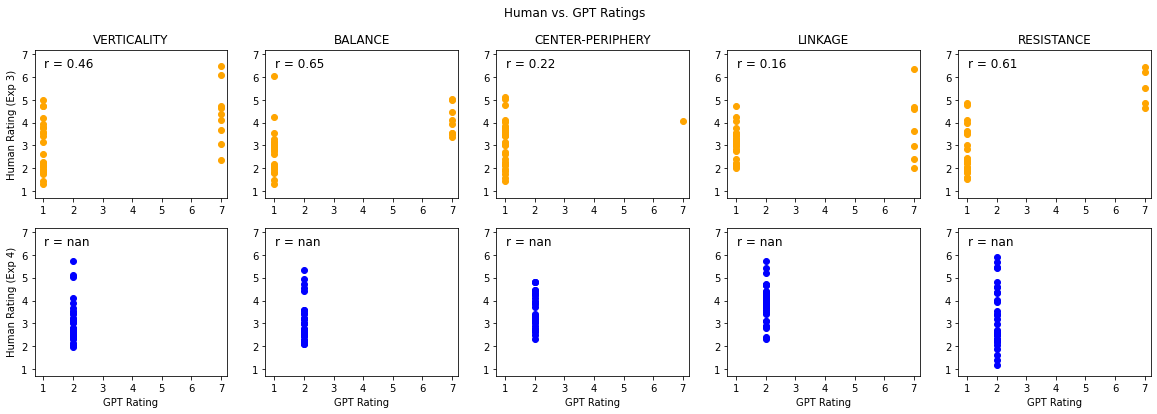

In [161]:
make_scatter_plots(full_history_results_exp3, full_history_results_exp4, "Human vs. GPT Ratings")

rate all stimuli for one IS:

In [39]:
model="gpt-3.5-turbo-0613"
history_results_exp3={}
history_results_exp4={}
for key in DEFINITIONS:
    print("\n", key)
    history_results_exp3[key] = []
    history_results_exp4[key] = []
    gpt_c3=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=STIMULI_EXP3) 
    time.sleep(RATE_LIMIT)
    gpt_c4=gpt_with_nearly_full_instructions(model=model, image_schema=key, stimuli=STIMULI_EXP4)
    time.sleep(RATE_LIMIT)
    # extract numbers from response
    c3=gpt_c3["choices"][0]["message"]["content"]
    c4=gpt_c4["choices"][0]["message"]["content"]
    print("\nExperiment 3")
    print(c3)
    print("\nExperiment 4")
    print(c4)
    c3=c3.split("\n")
    c4=c4.split("\n")
    c3=[i.split(":")[1].strip() for i in c3]
    c4=[i.split(":")[1].strip() for i in c4]
    history_results_exp3[key]=c3
    history_results_exp4[key]=c4

for IS in history_results_exp3:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp3[IS] = [int(rating) for rating in history_results_exp3[IS]]
for IS in history_results_exp4:
    # turn list of strings (e.g. ["1","2"]) into ints (e.g. [1,2])
    history_results_exp4[IS] = [int(rating) for rating in history_results_exp4[IS]]


 VERTICALITY

Experiment 3
1: 6
2: 4
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 6
12: 6
13: 2
14: 5
15: 6
16: 6
17: 6
18: 5
19: 6
20: 5
21: 5
22: 6
23: 6
24: 6
25: 5
26: 5
27: 6
28: 4
29: 6
30: 6
31: 4
32: 6

Experiment 4
1: 2
2: 1
3: 6
4: 2
5: 4
6: 5
7: 3
8: 2
9: 4
10: 2
11: 7
12: 7
13: 1
14: 4
15: 2
16: 7
17: 2
18: 3
19: 2
20: 4
21: 3
22: 2
23: 7
24: 7
25: 4
26: 5
27: 5
28: 2
29: 6
30: 1
31: 3
32: 6

 BALANCE

Experiment 3
1: 1
2: 2
3: 6
4: 5
5: 6
6: 6
7: 6
8: 4
9: 3
10: 2
11: 1
12: 3
13: 2
14: 4
15: 6
16: 5
17: 6
18: 5
19: 6
20: 4
21: 5
22: 5
23: 6
24: 4
25: 4
26: 4
27: 6
28: 3
29: 6
30: 6
31: 4
32: 5

Experiment 4
1: 1
2: 2
3: 6
4: 1
5: 4
6: 6
7: 5
8: 4
9: 6
10: 2
11: 1
12: 3
13: 1
14: 4
15: 5
16: 3
17: 2
18: 3
19: 4
20: 4
21: 3
22: 1
23: 3
24: 3
25: 4
26: 5
27: 6
28: 2
29: 5
30: 2
31: 3
32: 6

 CENTER-PERIPHERY

Experiment 3
1: 1
2: 4
3: 5
4: 6
5: 6
6: 6
7: 6
8: 4
9: 3
10: 4
11: 2
12: 3
13: 4
14: 4
15: 5
16: 6
17: 5
18: 5
19: 6
20: 4
21: 5
22: 6
23: 3
24: 4
25: 4
26: 5
27: 6
28

In [133]:
print_correlations(history_results_exp3, history_results_exp4)

VERTICALITY
Experiment 3: SpearmanrResult(correlation=0.39248203951590666, pvalue=0.02629062682584727)
Experiment 4: SpearmanrResult(correlation=0.18066380733387408, pvalue=0.3224178507761486)

BALANCE
Experiment 3: SpearmanrResult(correlation=0.13341795203218007, pvalue=0.46663645952245225)
Experiment 4: SpearmanrResult(correlation=0.22565818366289975, pvalue=0.21430256336588713)

CENTER-PERIPHERY
Experiment 3: SpearmanrResult(correlation=0.45838062223891046, pvalue=0.008328988276605017)
Experiment 4: SpearmanrResult(correlation=0.03487005828984612, pvalue=0.8497289613404104)

LINKAGE
Experiment 3: SpearmanrResult(correlation=0.640534792236373, pvalue=7.853556238578637e-05)
Experiment 4: SpearmanrResult(correlation=0.4047371197296721, pvalue=0.021575491456038046)

RESISTANCE
Experiment 3: SpearmanrResult(correlation=0.499589546870746, pvalue=0.0036003409174275905)
Experiment 4: SpearmanrResult(correlation=0.7112514570467381, pvalue=5.0445279741929784e-06)



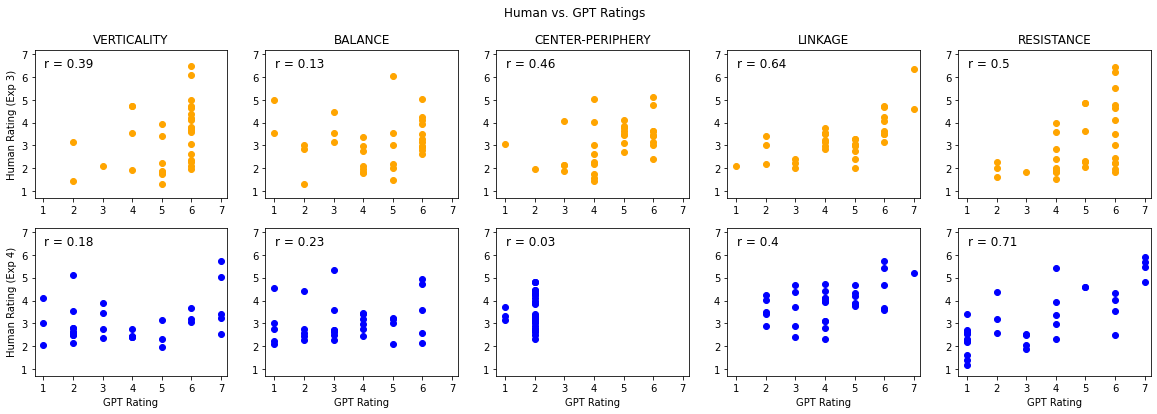

In [124]:
make_scatter_plots(history_results_exp3, history_results_exp4, "Human vs. GPT Ratings")